In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [5]:
x_train_nhts = np.load("data/x_train_nhts.npy")
x_test_nhts = np.load("data/x_test_nhts.npy")
 
x_train_images = np.load("data/x_train_images.npy")
x_test_images = np.load("data/x_test_images.npy")
  

y_train = np.load("data/y_train.npy")
y_test = np.load("data/y_test.npy")
print("The sample size of training set is: ", x_train_nhts.shape[0])
print("The sample size of testing set is: ", x_test_nhts.shape[0])

The sample size of training set is:  3556
The sample size of testing set is:  889


In [6]:
# bridge numpy to torch
x_train_nhts_torch = torch.as_tensor(x_train_nhts).float() # specify floats for the inputs
x_train_images_torch = torch.as_tensor(x_train_images).float()
x_test_nhts_torch = torch.as_tensor(x_test_nhts).float()
x_test_images_torch = torch.as_tensor(x_test_images).float()
y_train_torch = torch.as_tensor(y_train[:,0])
y_test_torch = torch.as_tensor(y_test[:,0])
n_train = x_train_nhts.shape[0]
n_test = x_test_nhts.shape[0]
# inputs: x_train_nhts, x_train_images, x_test_nhts, x_test_images, y_train, and y_test; 
K = len(np.unique(y_train))
x_dim = x_train_nhts.shape[1]
# 
pd.value_counts(y_train[:,0])/y_train.shape[0]

2    0.339426
1    0.324241
3    0.250562
0    0.085771
dtype: float64

In [7]:
##### Type 1: with only NHTS dataset.
class NN(nn.Module):  # subclass nn.Module
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(x_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 256)
        self.fc8 = nn.Linear(256, 512)
        self.fc9 = nn.Linear(512, K)
        self.softmax = nn.Softmax(dim=1)  
    def forward(self, x):
        print(x.shape)
        x = self.fc1(x)
        x = x.relu()
        print(x.shape)
        x = self.fc2(x)
        x = x.relu()
        print(x.shape)
        x = self.fc3(x)
        x = x.relu()
        print(x.shape)
        x = self.fc4(x)
        x = x.relu()
        print(x.shape)
        x = self.fc5(x)
        x = x.relu()
        print(x.shape)
        x = self.fc6(x)
        x = x.relu()
        print(x.shape)
        x = self.fc7(x)
        x = x.relu()
        print(x.shape)
        x = self.fc8(x)
        x = x.relu()
        print(x.shape)
        x = self.fc9(x)
        x = x.relu()
        print(x.shape)
        x = self.softmax(x)
        print(x.shape)
        return x

In [8]:
net = NN().float().to(device)
print(type(net))
optim = torch.optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 500 # so many?
batch_size = 200 

<class '__main__.NN'>


In [9]:
# training
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for n_epoch in range(n_epoches):
    # create permutation for batch training
    permutation = torch.randperm(x_train_nhts_torch.size()[0])
    for i in range(0, x_train_nhts_torch.size()[0], batch_size):
        # clear gradients first (for each iteration!)!
        optim.zero_grad()
        # forward pass
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train_nhts_torch[indices].to(device), y_train_torch[indices].to(device)
        batch_y_pred_train = net(batch_x).to(device)
        # loss 
        loss = criterion(batch_y_pred_train.squeeze(), batch_y)
        # compute gradients
        loss.backward()
        # one step optim
        optim.step()

    # eval training accuracy
    with torch.no_grad():
        y_pred_train = net(x_train_nhts_torch.to(device))
        loss_train = criterion(y_pred_train.squeeze(), y_train_torch.to(device))
        train_losses.append(loss_train)
        _, predict_train = torch.max(y_pred_train, axis = 1)
        accuracy_train = (predict_train == y_train_torch.to(device)).sum().item()/n_train  
        train_accuracies.append(accuracy_train)
        # evaluate testing sets step-wise
        net.eval()
        y_pred_test = net(x_test_nhts_torch.to(device))
        loss_test = criterion(y_pred_test.squeeze(), y_test_torch.to(device))
        test_losses.append(loss_test)
        _, predict_test = torch.max(y_pred_test.to(device), axis = 1)
        accuracy_test = (predict_test == y_test_torch.to(device)).sum().item()/n_test
        test_accuracies.append(accuracy_test)
        # print info    
        if n_epoch % 5 == 0:
            print('Epoch {}: train loss: {}; test loss: {}'.format(n_epoch, loss.item(), loss_test.item()))
            print('Epoch {}: train accuracy: {}; test accuracy: {}'.format(n_epoch, accuracy_train, accuracy_test)) 
    # Note: about 60% accuracy for both training and testing. (with n_epoches = 500; batch_size = 200)

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([2

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([355

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([20

torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
Epoch 270: train loss: 1.3862944841384888; test loss: 1.386294960975647
Epoch 270: train accuracy: 0.08577052868391451; test accuracy: 0.09111361079865017
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

Epoch 405: train loss: 1.3862944841384888; test loss: 1.386294960975647
Epoch 405: train accuracy: 0.08577052868391451; test accuracy: 0.09111361079865017
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 1

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556, 22])
torch.Size([3556, 64])
torch.Size([3556, 64])
torch.Size([3556, 128])
torch.Size([3556, 128])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 256])
torch.Size([3556, 512])
torch.Size([3556, 4])
torch.Size([3556, 4])
torch.Size([889, 22])
torch.Size([889, 64])
torch.Size([889, 64])
torch.Size([889, 128])
torch.Size([889, 128])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 256])
torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
Epoch

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([156, 22])
torch.Size([156, 64])
torch.Size([156, 64])
torch.Size([156, 128])
torch.Size([156, 128])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 256])
torch.Size([156, 512])
torch.Size([156, 4])
torch.Size([156, 4])
torch.Size([3556

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200,

torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200,

torch.Size([889, 512])
torch.Size([889, 4])
torch.Size([889, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200, 64])
torch.Size([200, 64])
torch.Size([200, 128])
torch.Size([200, 128])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 256])
torch.Size([200, 512])
torch.Size([200, 4])
torch.Size([200, 4])
torch.Size([200, 22])
torch.Size([200,

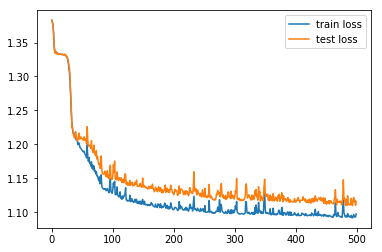

In [8]:
plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "test loss")
plt.legend()



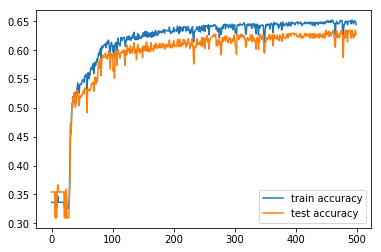

In [9]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(test_accuracies, label = "test accuracy")
plt.legend()

In [10]:
torch.save(net.state_dict(), "data/nn_ADAM_8fc")